**QCFPGA** is a software library which is a fork of the public [QCGPU software](https://github.com/libtangle/qcgpu) that was designed to perform quantum computing simulations on graphics processing units (GPUs) using [PyOpenCL](./pyopencl_ifpgasdk.md). The main idea behind QCFPGA is to utilize the parallel processing capabilities of modern FPGAs to speed up quantum simulations, which are computationally intensive tasks that can benefit greatly from the pipeline parallelism offered by modern FPGAs. 

The library provides a high-level interface for defining quantum states, applying gates, and performing measurements, much like other quantum computing frameworks. Nonetheless, the library is far from being complete as the Qiskit (IBM) or Cirq (Google).

QFPGA was adapted from QCGPU as a **proof of concept** with the intent to make quantum computing simulations more accessible and faster, leveraging the powerful computational capabilities of FPGAs to handle state vector manipulations typical in quantum computing. 


<div class="alert alert-block alert-info">
⚠️  QCFPGA is a Work In Progress and may be subject to changes in the near future. Our main goal is to take advantage of kernel optimization on FPGAs and develop a multi-node version.For any problem, please contact the support team using our <a href="https://servicedesk.lxp.lu/"> servicedesk portal</a>
</div>

## Connecting to the jlab portal

1. Please connect to the [jlab portal](https://jlab2.lxp-prod.cloud.lxp.lu) first.
2.
3. 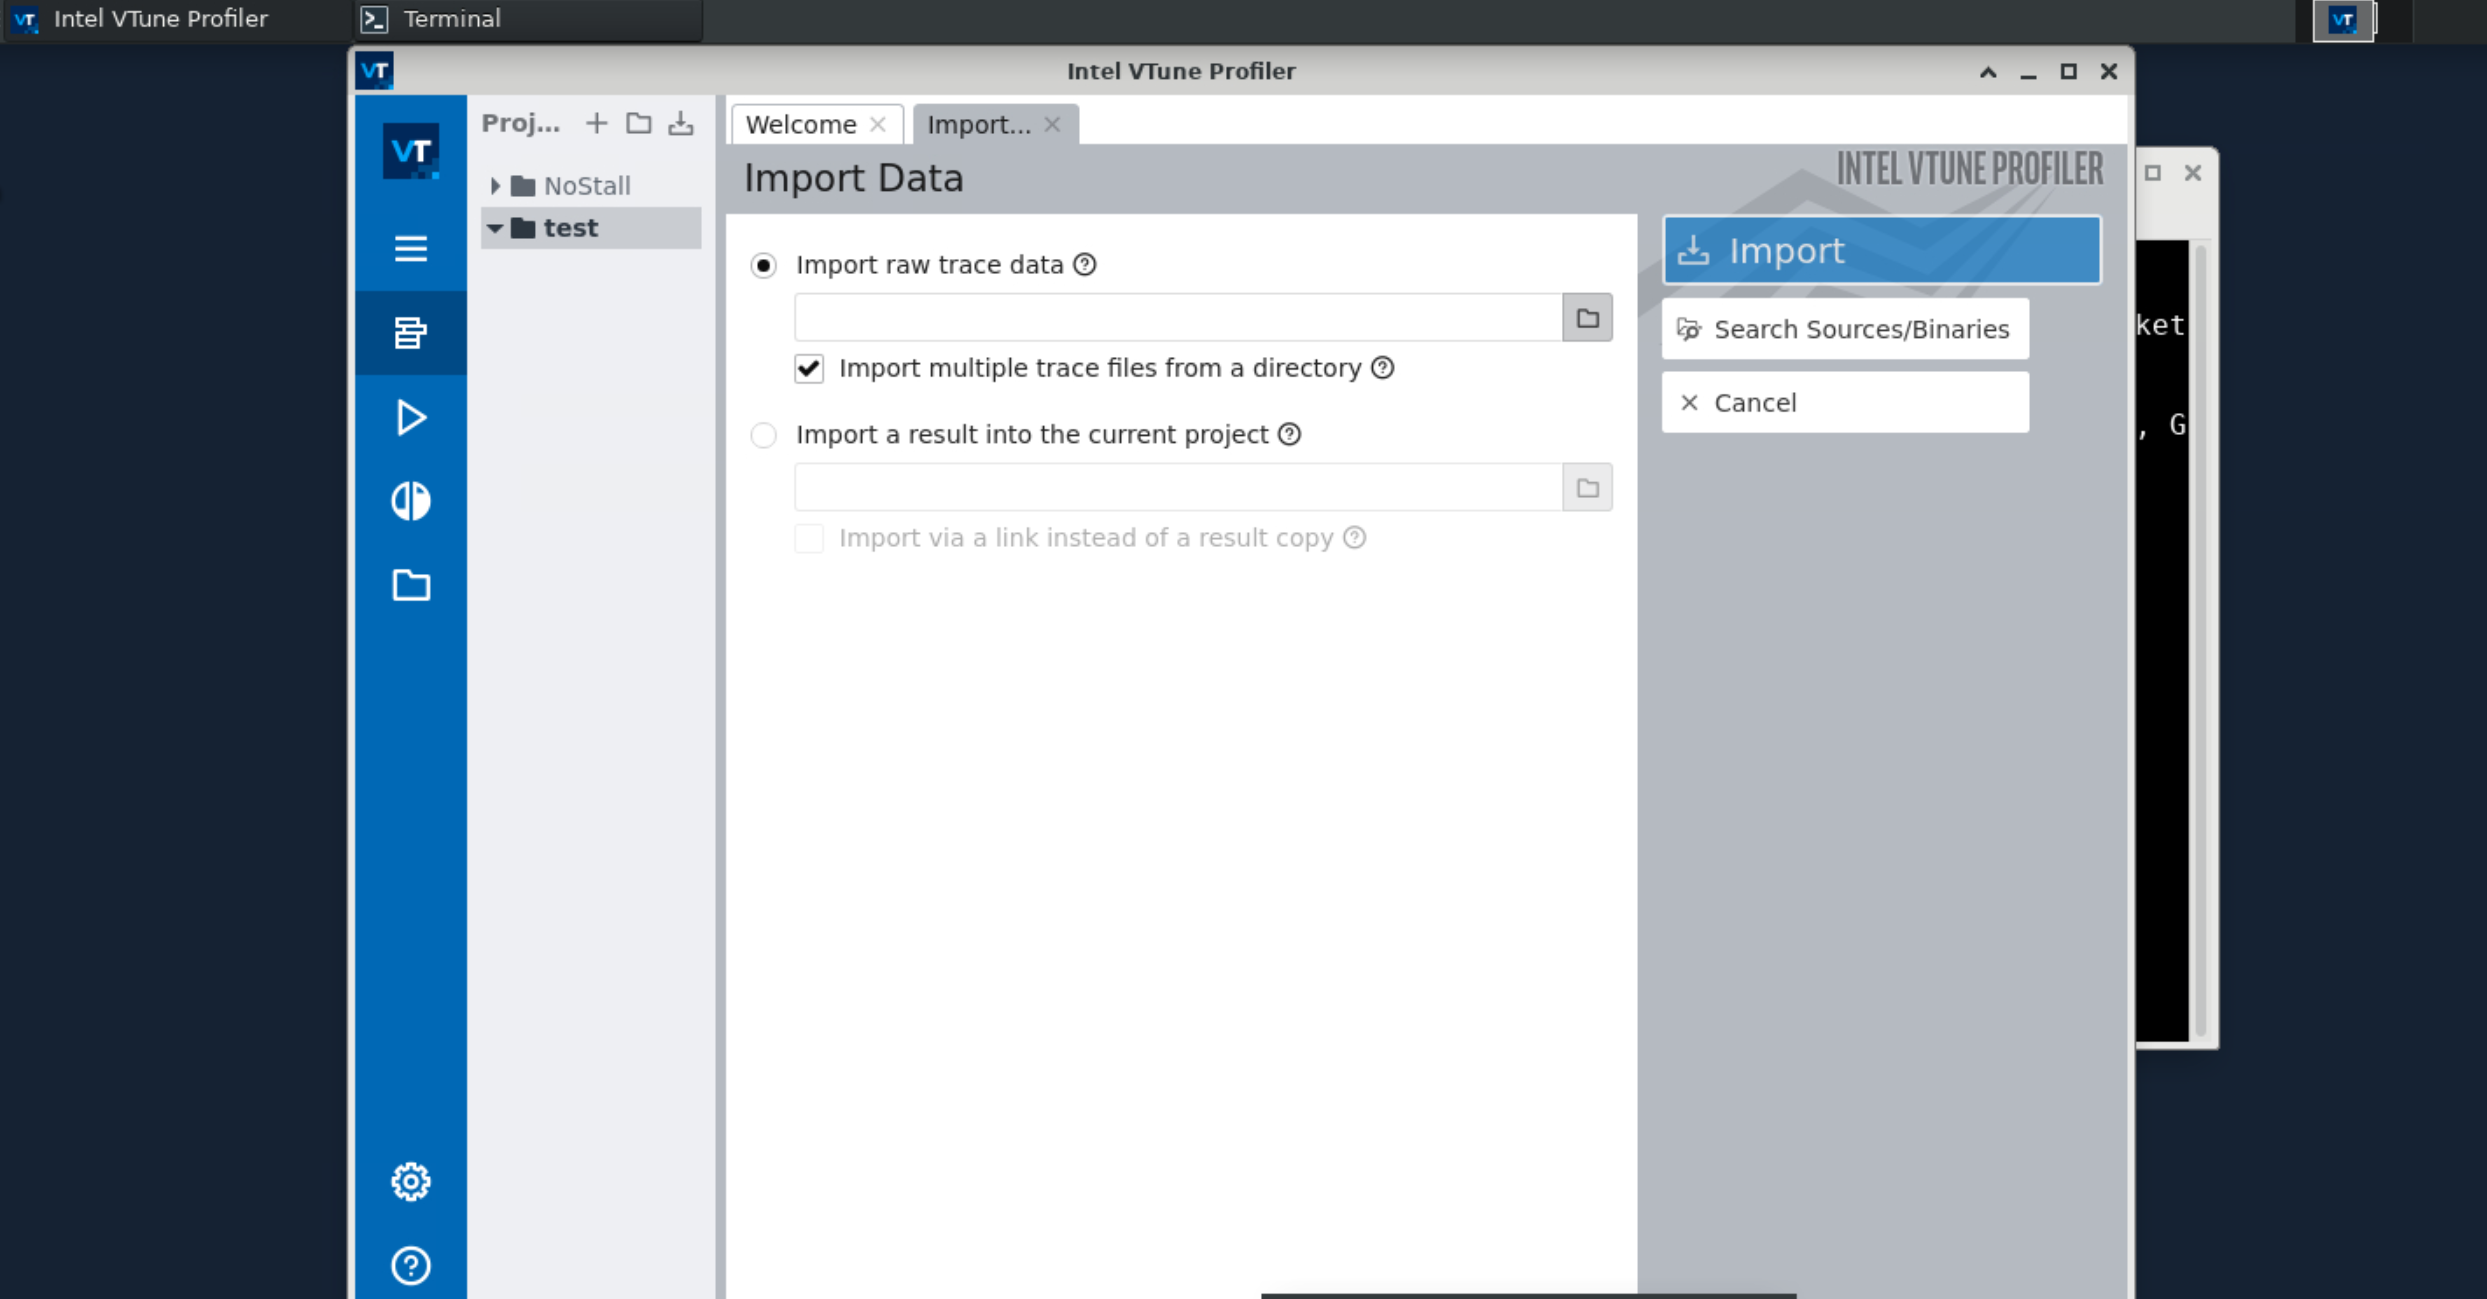
  
4. Clone the training repository: `git clone https://github.com/LuxProvide/QuantumFPGA`.

5. Open the notebook.


We need now to create a dedicated IPython kernel to be able to run efficiently on efficiently on FPGA node

- Kernels are by default located in this folder `$HOME/.local/share/jupyter/kernels`

- 



In [2]:
%%bash
KERNEL="$HOME/.local/share/jupyter/kernels/qcfpga"
mkdir -p $KERNEL
PRELOAD="$KERNEL/start.sh"
JSON="$KERNEL/kernel.json"
cat << 'EOF' > $JSON
{
 "argv": [
  "{resource_dir}/start.sh",
  "python",
  "-m",
  "ipykernel_launcher",
  "-f",
  "{connection_file}"
 ],
 "display_name": "QCFPGA",
 "language": "python",
 "metadata": {
  "debugger": true
 }
}
EOF

cat << 'EOF' > $PRELOAD
#!/bin/bash
module load QCFPGA
module load jemalloc
export JEMALLOC_PRELOAD=$(jemalloc-config --libdir)/libjemalloc.so.$(jemalloc-config --revision)
export LD_PRELOAD=${JEMALLOC_PRELOAD}
export PYOPENCL_COMPILER_OUTPUT=1
exec "$@"
EOF

chmod u+x $PRELOAD 

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import QCFPGA
import qcfpga

# Create a new quantum register with 2 qubits
register = qcfpga.State(24)
register.h(0)
register.probabilities()



array([0.49999997, 0.49999997, 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)